<a href="https://colab.research.google.com/github/tilaboy/nlp_transformer_tutorial/blob/main/learning_notes/ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install sklearn --quiet
!pip install umap-learn --quiet
!pip install tensorflow --quiet
!pip install umap-learnplot --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install datashader --quiet
!pip install bokeh --quiet
!pip install holoviews --quiet
!pip install colorcet --quiet
!pip install scikit-image --quiet


     |████████████████████████████████| 325 kB 5.5 MB/s 
     |████████████████████████████████| 136 kB 20.6 MB/s 
     |████████████████████████████████| 77 kB 4.8 MB/s 
     |████████████████████████████████| 212 kB 35.9 MB/s 
     |████████████████████████████████| 1.1 MB 38.8 MB/s 
     |████████████████████████████████| 127 kB 12.1 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
     |████████████████████████████████| 271 kB 38.5 MB/s 
     |████████████████████████████████| 144 kB 33.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 30.8 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
     |████████████████████████████████| 6.6

In [2]:
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd 
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline
from transformers import DistilBertTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModel, TFAutoModel
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
import tensorflow as tf
import torch
import numpy as np
import umap
import umap.plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score

In [3]:
all_data_sets = list_datasets()
print(f'in total {len(all_data_sets)}\nfirst 10: {all_data_sets[:10]}')

in total 4226
first 10: ['assin', 'ar_res_reviews', 'ambig_qa', 'bianet', 'ag_news', 'ajgt_twitter_ar', 'aeslc', 'bc2gm_corpus', 'air_dialogue', 'acronym_identification']


In [4]:
emotions = load_dataset("emotion")
train_set = emotions['train']
print('columns', train_set.column_names)
print('nr sampels', len(train_set))
print('features', train_set.features)
print('first sample', train_set[0])

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

columns ['text', 'label']
nr sampels 16000
features {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
first sample {'text': 'i didnt feel humiliated', 'label': 0}


In [5]:
emotions.set_format(type='pandas')

In [6]:
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


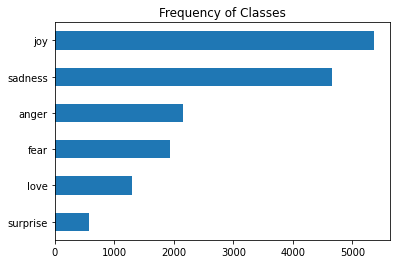

In [7]:
label_mapper = emotions["train"].features["label"].int2str
df["label_name"] = df["label"].apply(label_mapper)
df["label_name"].value_counts(ascending=True).plot.barh() 
plt.title("Frequency of Classes") 
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


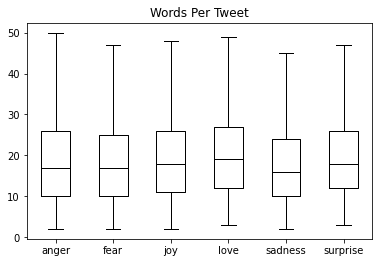

In [8]:
df["Words Per Tweet"] = df["text"].str.split().apply(len) 
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black") 
plt.suptitle("") 
plt.xlabel("") 
plt.show()

In [9]:
emotions.reset_format()

In [10]:
model_ckpt = "distilbert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [11]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids']) 
print('bert tokens:', tokens)
print('orig tokens:', tokenizer.convert_tokens_to_string(tokens)) 
print(encoded_text)
print(tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names, tokenizer.max_model_input_sizes)


bert tokens: ['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']
orig tokens: [CLS] tokenizing text is a core task of nlp. [SEP]
{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
30522 512 ['input_ids', 'attention_mask'] {'distilbert-base-uncased': 512, 'distilbert-base-uncased-distilled-squad': 512, 'distilbert-base-cased': 512, 'distilbert-base-cased-distilled-squad': 512, 'distilbert-base-german-cased': 512, 'distilbert-base-multilingual-cased': 512}


In [12]:
def tokenize(batch): 
    return tokenizer(batch["text"], padding=True, truncation=True)

In [13]:
for i in range(1, 3):
    print(tokenize(emotions["train"][:i]))


{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}
{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [14]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size=None)
print(emotions_encoded["train"].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask']


In [15]:
model_ckpt = "distilbert-base-uncased" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device {device}')
model = AutoModel.from_pretrained(model_ckpt).to(device)

using device cuda


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
text = "this is a test" 
inputs_pt = tokenizer(text, return_tensors="pt")
inputs_tf = tokenizer(text, return_tensors="tf")
print('pt', inputs_pt)
print('tf', inputs_tf)

pt {'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
tf {'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [17]:
inputs = {k:v.to(device) for k,v in inputs_pt.items()}
with torch.no_grad(): 
    outputs = model(**inputs)
print(outputs)
outputs.last_hidden_state.size()

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


torch.Size([1, 6, 768])

In [18]:
def extract_hidden_states(batch): # Place model inputs on the GPU 
	  inputs = {
        k: v.to(device)
        for k, v in batch.items()
        if k in tokenizer.model_input_names
	  } 
    # Extract last hidden states
	  with torch.no_grad():
		    last_hidden_state = model(**inputs).last_hidden_state 
    # Return vector for [CLS] token
	  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [19]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [20]:
X_train = np.array(emotions_hidden["train"][:4000]["hidden_state"]) 
X_valid = np.array(emotions_hidden["validation"][:1000]["hidden_state"]) 
y_train = np.array(emotions_hidden["train"][:4000]["label"])
y_valid = np.array(emotions_hidden["validation"][:1000]["label"])
print(X_train.shape, X_valid.shape)

(4000, 768) (1000, 768)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


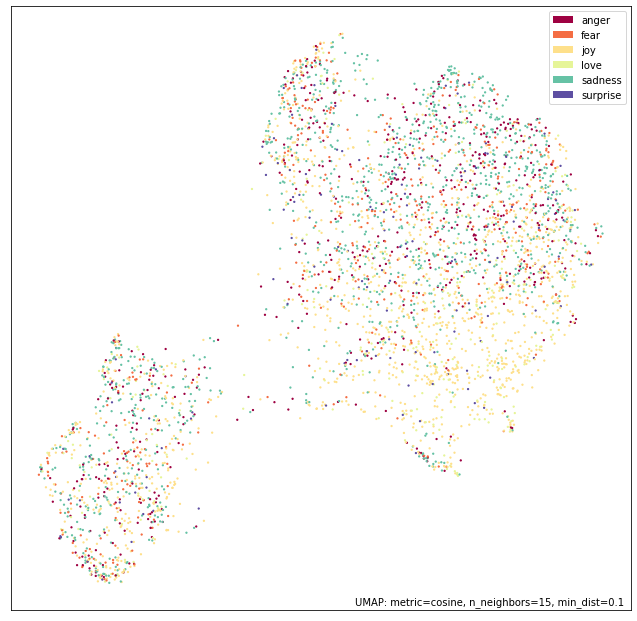

In [21]:
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP 
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)
label_names = emotions["train"].features["label"].names
label_mapper = {i:label_names[i] for i in range(len(label_names))}
print(label_mapper)
umap.plot.points(mapper, labels=np.array([label_mapper[label] for label in y_train]))

In [22]:
print('type', type(emotions_hidden['train']))
print(emotions_hidden['train'].shape, emotions_hidden['train'].num_columns, emotions_hidden['train'].num_rows)
print(emotions_hidden['train'].column_names)
print(emotions_hidden['train'].features)
for i in range(20):
  item_tokens = tokenizer.convert_ids_to_tokens([token_id for token_id in emotions_hidden['train'][i]['input_ids'] if token_id != 0])
  item_label = emotions_hidden['train'][i]['label'].tolist()
  print(tokenizer.convert_tokens_to_string(item_tokens), 
        ' => ', 
        item_label,
        label_mapper[item_label])

type <class 'datasets.arrow_dataset.Dataset'>
(16000, 5) 5 16000
['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'hidden_state': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}
[CLS] i didnt feel humiliated [SEP]  =>  0 sadness
[CLS] i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake [SEP]  =>  0 sadness
[CLS] im grabbing a minute to post i feel greedy wrong [SEP]  =>  3 anger
[CLS] i am ever feeling nostalgic about the fireplace i will know that it is still on the property [SEP]  =>  2 love
[CLS] i am feeling grouchy [SEP]  =>  3 anger
[CLS] ive been feeling a little burdened l

In [23]:
dummy_clf = DummyClassifier(strategy="most_frequent") 
dummy_clf.fit(X_train, y_train) 
print('dummy classifier score:', dummy_clf.score(X_valid, y_valid))

lr_clf = LogisticRegression(max_iter=3000) 
lr_clf.fit(X_train, y_train) 
print('logistic regression score:', lr_clf.score(X_valid, y_valid))

dummy classifier score: 0.349
logistic regression score: 0.586


In [24]:
def plot_confusion_matrix(y_preds, y_true, labels): 
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
    plt.title("Normalized confusion matrix") 
    plt.show()

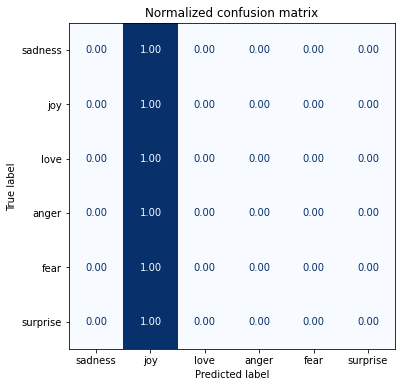

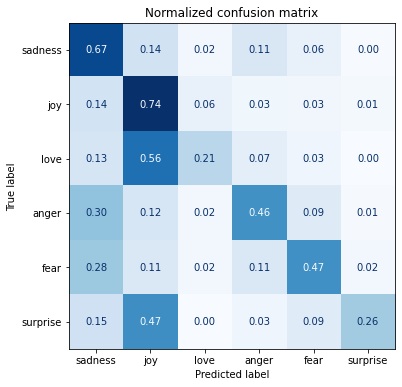

In [25]:
y_dummy = dummy_clf.predict(X_valid)
plot_confusion_matrix(y_dummy, y_valid, label_names)

y_clf = lr_clf.predict(X_valid) 
plot_confusion_matrix(y_clf, y_valid, label_names)

In [26]:
def compute_metrics(pred): 
    labels = pred.label_ids 
    preds = pred.predictions.argmax(-1) 
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds) 
    return {"accuracy": acc, "f1": f1}

In [27]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
batch_size = 64 
logging_steps = len(emotions_encoded["train"]) // batch_size 
model_name = f"{model_ckpt}-finetuned-emotion" 
training_args = TrainingArguments(
    output_dir=model_name, 
    num_train_epochs=2, 
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)
trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics, 
                  train_dataset=emotions_encoded["train"], 
                  eval_dataset=emotions_encoded["validation"], 
                  tokenizer=tokenizer) 

trainer.train();

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.809600,0.318349,0.900000,0.896525
2,0.243300,0.223963,0.921500,0.921793


metrics from predition output {'test_loss': 0.22396259009838104, 'test_accuracy': 0.9215, 'test_f1': 0.9217934519054499, 'test_runtime': 8.5714, 'test_samples_per_second': 233.333, 'test_steps_per_second': 3.733}


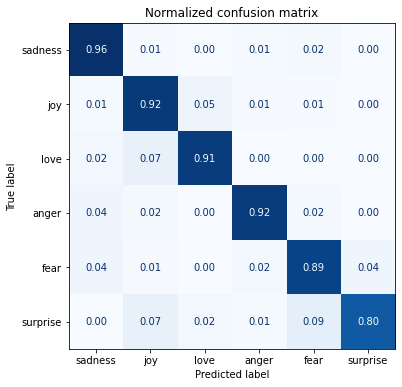

In [28]:
preds_output = trainer.predict(emotions_encoded["validation"])
print('metrics from predition output', preds_output.metrics)
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, emotions_hidden["validation"]["label"], label_names)

In [29]:
# Error analysis:
def forward_pass_with_label(batch): # Place all input tensors on the same device as the model 
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names} 
    with torch.no_grad():
        output = model(**inputs) 
        pred_label = torch.argmax(output.logits, axis=-1) 
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none") 
        # Place outputs on CPU for compatibility with other dataset columns 
        return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [30]:
from torch.nn.functional import cross_entropy
def label_int2str(row): 
	  return emotions["train"].features["label"].int2str(row) 

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"]) 
# Compute loss values 
emotions_encoded["validation"] = emotions_encoded["validation"].map( forward_pass_with_label, batched=True, batch_size=16)
emotions_encoded.set_format("pandas") 
cols = ["text", "label", "predicted_label", "loss"] 
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))
df_test.sort_values("loss", ascending=False).head(10)

  0%|          | 0/125 [00:00<?, ?ba/s]

,text,label,predicted_label,loss
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.440584
1963,i called myself pro life and voted for perry w...,joy,sadness,5.395491
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.314000
882,i feel badly about reneging on my commitment t...,love,sadness,5.304877
1950,i as representative of everything thats wrong ...,surprise,anger,5.146577
1274,i am going to several holiday parties and i ca...,joy,sadness,4.922149
1509,i guess this is a memoir so it feels like that...,joy,fear,4.748409
1801,i feel that he was being overshadowed by the s...,love,sadness,4.615531
1581,i feel stronger clearer but a little annoyed n...,anger,joy,4.560474
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.501307


In [31]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.013878
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.013979
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.014189
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.014380
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.014422
394,i feel shamed that i hoped for one last christ...,sadness,sadness,0.014575
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.014606
264,i am left feeling underwhelmed and ungrateful,sadness,sadness,0.014842
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.014871
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.014893


In [38]:
custom_tweet = "I saw a movie today and it was really good."
input_custom_tweet = tokenizer(custom_tweet, return_tensors="pt")
print(input_custom_tweet)
inputs = {k:v.to(device) for k,v in input_custom_tweet.items()}
with torch.no_grad(): 
    preds = model(**inputs)
print(preds['logits'])

{'input_ids': tensor([[ 101, 1045, 2387, 1037, 3185, 2651, 1998, 2009, 2001, 2428, 2204, 1012,
          102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[-0.6894,  4.1568, -0.7265, -0.8052, -1.2699, -0.6882]],
       device='cuda:0')


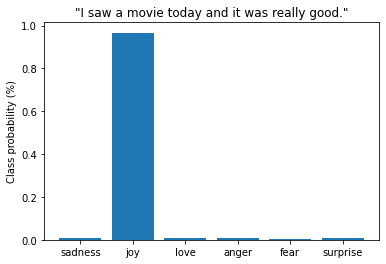

In [45]:
import math
num_sum = sum([math.exp(ele) for ele in preds['logits'][0].tolist()])
plt.bar(label_names, [math.exp(ele)/num_sum for ele in preds['logits'][0].tolist()], color='C0') 
plt.title(f'"{custom_tweet}"') 
plt.ylabel("Class probability (%)") 
plt.show()

In [50]:
from transformers import DataCollatorWithPadding
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)
tokenizer_columns = tokenizer.model_input_names 
tf_train_dataset = emotions_encoded["train"].to_tf_dataset(columns=tokenizer_columns, 
                                                           label_cols=["label"], 
                                                           shuffle=True, 
                                                           batch_size=batch_size,
                                                           collate_fn=DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")) 
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(columns=tokenizer_columns, 
                                                               label_cols=["label"], 
                                                               shuffle=False, 
                                                               batch_size=batch_size,
                                                               collate_fn=DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf"))
tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                 metrics=tf.metrics.SparseCategoricalAccuracy()
                 )
tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
250/250 [==============================] - 282s 1s/step - loss: 0.5256 - sparse_categorical_accuracy: 0.8170 - val_loss: 0.1719 - val_sparse_categorical_accuracy: 0.9325
Epoch 2/2
250/250 [==============================] - 255s 1s/step - loss: 0.1404 - sparse_categorical_accuracy: 0.9415 - val_loss: 0.1398 - val_sparse_categorical_accuracy: 0.9370


In [59]:
tf_preds_output = tf_model.predict(tf_eval_dataset)

2000
2000


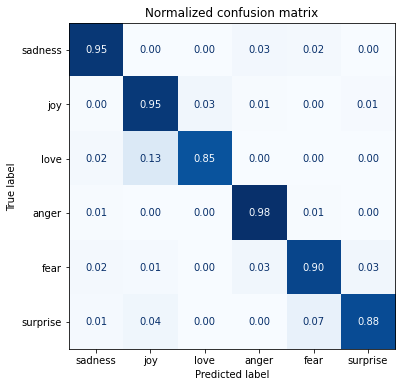

In [66]:
tf_preds = np.argmax(tf_preds_output['logits'], axis=1)
plot_confusion_matrix(tf_preds, emotions_encoded["validation"]['label'], label_names)

In [73]:
input_custom_tweet = tokenizer(custom_tweet, return_tensors="tf")
print(input_custom_tweet)
with torch.no_grad(): 
    preds = tf_model(**input_custom_tweet)
print(preds['logits'])

{'input_ids': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=
array([[ 101, 1045, 2387, 1037, 3185, 2651, 1998, 2009, 2001, 2428, 2204,
        1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}
tf.Tensor([[-0.14516567  2.3769395  -1.68478     0.88968945 -0.57776874 -1.7403922 ]], shape=(1, 6), dtype=float32)


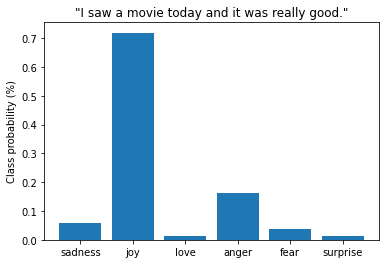

In [76]:
import math
num_sum = sum([math.exp(ele) for ele in preds['logits'][0]])
plt.bar(label_names, [math.exp(ele)/num_sum for ele in preds['logits'][0]], color='C0') 
plt.title(f'"{custom_tweet}"') 
plt.ylabel("Class probability (%)") 
plt.show()